미국 주식 48%, 선진국 주식 24%, 미국 부동산 8%, 미국 채권 20% 비중으로 가져가는 전략입니다.

In [1]:
import pandas as pd
import pandas_datareader.data as web
import datetime
import numpy as np
%matplotlib inline
import backtrader as bt
import matplotlib.pyplot as plt
import pyfolio as pf
import quantstats
import math
plt.rcParams["figure.figsize"] = (10, 6) # (w, h)

C:\ProgramData\Anaconda3\lib\site-packages\pyfolio\pos.py:27: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  'Module "zipline.assets" not found; mutltipliers will not be applied' +


ETF로 매수하는 것이 간편하니 적절한 ETF 데이터를 다운받습니다. 미국 전체 주식 ETF인 VTI, 선진국 주식 ETF인 EFA, 미국 부동산 ETF VNQ, 미국 채권 ETF인 AGG를 사용합니다.

In [2]:
start = '2004-10-02'
end = '2021-03-19'
vti = web.DataReader("VTI", 'yahoo', start, end)['Adj Close'].to_frame("vti_Close")
efa = web.DataReader("EFA", 'yahoo', start, end)['Adj Close'].to_frame("efa_Close")
vnq = web.DataReader("VNQ", 'yahoo', start, end)['Adj Close'].to_frame("vnq_Close")
agg = web.DataReader("AGG", 'yahoo', start, end)['Adj Close'].to_frame("agg_Close")

In [3]:
vti.head()

,vti_Close
Date,
2004-10-01,39.929573
2004-10-04,40.060860
2004-10-05,40.049908
2004-10-06,40.294239
2004-10-07,39.929573


일단 모델 포트폴리오로, 매일 48:24:8:20 비중을 맞추는 것으로 생각하고 만듭니다. 거래비용은 생략합니다.

In [4]:
vti_return = vti.pct_change(periods=1)
efa_return = efa.pct_change(periods=1)
vnq_return = vnq.pct_change(periods=1)
agg_return = agg.pct_change(periods=1)
df_return = pd.concat([vti_return, efa_return, vnq_return, agg_return], axis=1)

df_return.head()

,vti_Close,efa_Close,vnq_Close,agg_Close
Date,,,,
2004-10-01,NaN,NaN,NaN,NaN
2004-10-04,0.003288,0.001532,0.004299,0.000294
2004-10-05,-0.000273,0.000557,-0.000195,-0.000098
2004-10-06,0.006101,0.003752,0.004670,-0.001859
2004-10-07,-0.009050,-0.006854,-0.010266,0.000000


In [5]:
df_return['CoreFour_return'] = df_return['vti_Close']*0.48 + df_return['efa_Close']*0.24 + df_return['vnq_Close']*0.08 + df_return['agg_Close']*0.2
df_return.head()

,vti_Close,efa_Close,vnq_Close,agg_Close,CoreFour_return
Date,,,,,
2004-10-01,NaN,NaN,NaN,NaN,NaN
2004-10-04,0.003288,0.001532,0.004299,0.000294,0.002349
2004-10-05,-0.000273,0.000557,-0.000195,-0.000098,-0.000033
2004-10-06,0.006101,0.003752,0.004670,-0.001859,0.003831
2004-10-07,-0.009050,-0.006854,-0.010266,0.000000,-0.006810


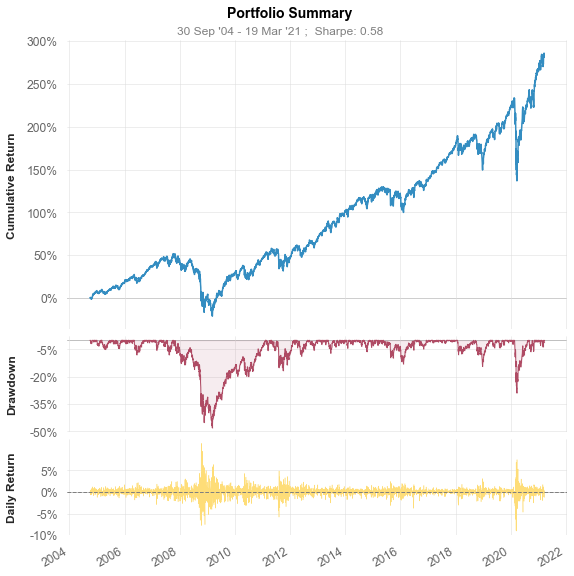

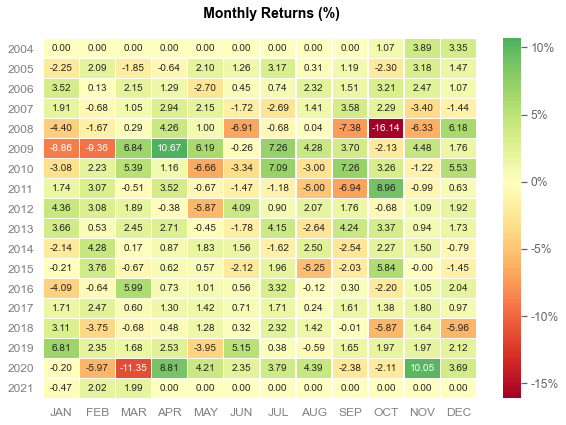

In [6]:
quantstats.reports.plots(df_return['CoreFour_return'], mode='basic')

매일 비중을 맞춘 결과 연 복리 수익률 8.46%, 샤프 비율 0.58, MDD -48% 정도입니다. MDD가 너무 높아 그리 좋은 전략은 아닙니다.

In [7]:
quantstats.reports.metrics(df_return['CoreFour_return'], mode='full')

                           Strategy
-------------------------  ----------
Start Period               2004-10-01
End Period                 2021-03-19
Risk-Free Rate             0.0%
Time in Market             100.0%

Cumulative Return          281.28%
CAGR%                      8.46%
Sharpe                     0.58
Sortino                    0.81
Max Drawdown               -48.12%
Longest DD Days            1217
Volatility (ann.)          16.31%
Calmar                     0.18
Skew                       -0.16
Kurtosis                   15.46

Expected Daily %           0.03%
Expected Monthly %         0.68%
Expected Yearly %          7.72%
Kelly Criterion            6.21%
Risk of Ruin               0.0%
Daily Value-at-Risk        -1.65%
Expected Shortfall (cVaR)  -1.65%

Payoff Ratio               0.88
Profit Factor              1.12
Common Sense Ratio         1.05
CPC Index                  0.56
Tail Ratio                 0.93
Outlier Win Ratio          4.79
Outlier Loss Ratio        

위에서 한 것처럼 그냥 만들어도 되지만, 백테스트에 많이 쓰이는 Backtrader 패키지를 한번 사용해 보겠습니다. Input 형식을 맞추어야 합니다.

In [8]:
vti = vti.rename({'vti_Close':'Close'}, axis='columns')
efa = efa.rename({'efa_Close':'Close'}, axis='columns')
vnq = vnq.rename({'vnq_Close':'Close'}, axis='columns')
agg = agg.rename({'agg_Close':'Close'}, axis='columns')

for column in ['Open', 'High', "Low"]:
    vti[column] = vti["Close"]
    efa[column] = efa["Close"]
    vnq[column] = vnq["Close"]
    agg[column] = agg["Close"]

In [9]:
vti.head()

,Close,Open,High,Low
Date,,,,
2004-10-01,39.929573,39.929573,39.929573,39.929573
2004-10-04,40.060860,40.060860,40.060860,40.060860
2004-10-05,40.049908,40.049908,40.049908,40.049908
2004-10-06,40.294239,40.294239,40.294239,40.294239
2004-10-07,39.929573,39.929573,39.929573,39.929573


48:24:8:20 비율로 매수하고 20 거래일마다 리밸런싱하는 전략입니다.

In [10]:
class AssetAllocation_CoreFour(bt.Strategy):
    params = (
        ('USequity',0.48),
        ('DEVequity', 0.24),
        ('USREITs', 0.08),
        ('USBond', 0.2),
    )
    def __init__(self):
        self.VTI = self.datas[0]
        self.EFA = self.datas[1]
        self.VNQ = self.datas[2]
        self.AGG = self.datas[3]
        self.counter = 0
        
    def next(self):
        if  self.counter % 20 == 0:
            self.order_target_percent(self.VTI, target=self.params.USequity)
            self.order_target_percent(self.EFA, target=self.params.DEVequity)
            self.order_target_percent(self.VNQ, target=self.params.USREITs)
            self.order_target_percent(self.AGG, target=self.params.USBond)
        self.counter += 1

In [12]:
cerebro = bt.Cerebro()

cerebro.broker.setcash(1000000)

VTI = bt.feeds.PandasData(dataname = vti)
EFA = bt.feeds.PandasData(dataname = efa)
VNQ = bt.feeds.PandasData(dataname = vnq)
AGG = bt.feeds.PandasData(dataname = agg)

cerebro.adddata(VTI)
cerebro.adddata(EFA)
cerebro.adddata(VNQ)
cerebro.adddata(AGG)

cerebro.addstrategy(AssetAllocation_CoreFour)

cerebro.addanalyzer(bt.analyzers.PyFolio, _name = 'PyFolio')

results = cerebro.run()
strat = results[0]

portfolio_stats = strat.analyzers.getbyname('PyFolio')
returns, positions, transactions, gross_lev = portfolio_stats.get_pf_items()
returns.index = returns.index.tz_convert(None)

#quantstats.reports.html(returns, output = 'Report_AssetAllocation_6040.html', title='AssetAllocation_6040')

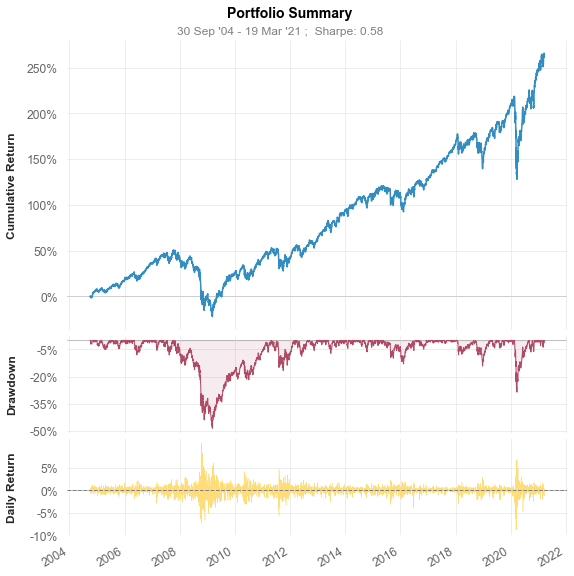

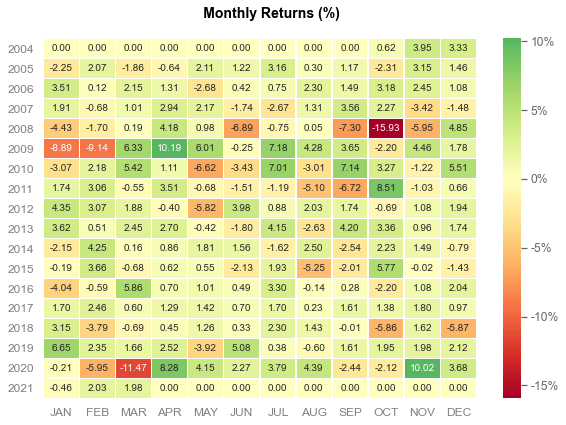

In [13]:
quantstats.reports.plots(returns, mode='basic')

20 거래일마다 리밸런싱하는 것으로 바꾸니 연 복리 수익률 8.11%, 샤프 비율 0.58, MDD -48% 정도로 나옵니다.

In [14]:
quantstats.reports.metrics(returns, mode='full')

                           Strategy
-------------------------  ----------
Start Period               2004-10-01
End Period                 2021-03-19
Risk-Free Rate             0.0%
Time in Market             100.0%

Cumulative Return          261.5%
CAGR%                      8.11%
Sharpe                     0.58
Sortino                    0.8
Max Drawdown               -48.33%
Longest DD Days            1294
Volatility (ann.)          15.71%
Calmar                     0.17
Skew                       -0.28
Kurtosis                   13.53

Expected Daily %           0.03%
Expected Monthly %         0.65%
Expected Yearly %          7.4%
Kelly Criterion            6.05%
Risk of Ruin               0.0%
Daily Value-at-Risk        -1.59%
Expected Shortfall (cVaR)  -1.59%

Payoff Ratio               0.88
Profit Factor              1.12
Common Sense Ratio         1.05
CPC Index                  0.55
Tail Ratio                 0.94
Outlier Win Ratio          4.69
Outlier Loss Ratio         4.

월간 데이터를 사용하면 훨씬 더 과거의 결과도 테스트해 볼 수 있습니다. 가장 긴 시계열의 경우 1900년 1월부터 2020년 12월까지의 데이터가 있습니다.

In [15]:
MonthlyReturn = pd.read_excel('MonthlyAssetClassReturn.xlsx')

In [16]:
MonthlyReturn.head()

,Data Index,Broker Call Rate,CPI,T-Bills,S&P 500 Total return,Small Cap Stocks,MSCI EAFE,EEM,US 10 YR,US Corp Bond Return Index,...,International Small Cap Value (Global B/M Small Low),International Large Cap Value (Global B/M Big Low),International Small High Mom (Global mom Small High),International Large High Mom (Global mom Small High),Merrill High Yield,World Stocks,World ex USA,BuyWrite,PutWrite,Bitcoin
0,1900-01-31,NaN,0.013333,0.0025,0.016413,NaN,NaN,NaN,0.000000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1900-02-28,NaN,0.000000,0.0025,0.021138,NaN,NaN,NaN,0.011278,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1900-03-31,NaN,0.000000,0.0025,0.011084,NaN,NaN,NaN,0.009758,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1900-04-30,NaN,0.000000,0.0025,0.015894,NaN,NaN,NaN,-0.016107,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1900-05-31,NaN,0.000000,0.0025,-0.044246,NaN,NaN,NaN,0.016023,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


시계열로 바꾸어 주는 것이 사용하기 편합니다. 1열인 Data Index가 월말 날짜이므로, 이 열을 인덱스로 잡습니다.

In [17]:
MonthlyReturn = MonthlyReturn.set_index('Data Index')

In [18]:
MonthlyReturn.head()

,Broker Call Rate,CPI,T-Bills,S&P 500 Total return,Small Cap Stocks,MSCI EAFE,EEM,US 10 YR,US Corp Bond Return Index,GSCI,...,International Small Cap Value (Global B/M Small Low),International Large Cap Value (Global B/M Big Low),International Small High Mom (Global mom Small High),International Large High Mom (Global mom Small High),Merrill High Yield,World Stocks,World ex USA,BuyWrite,PutWrite,Bitcoin
Data Index,,,,,,,,,,,,,,,,,,,,,
1900-01-31,NaN,0.013333,0.0025,0.016413,NaN,NaN,NaN,0.000000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1900-02-28,NaN,0.000000,0.0025,0.021138,NaN,NaN,NaN,0.011278,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1900-03-31,NaN,0.000000,0.0025,0.011084,NaN,NaN,NaN,0.009758,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1900-04-30,NaN,0.000000,0.0025,0.015894,NaN,NaN,NaN,-0.016107,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1900-05-31,NaN,0.000000,0.0025,-0.044246,NaN,NaN,NaN,0.016023,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


필요한 것만 뽑아옵니다. 미국 전체 채권 데이터가 없으니 10년 만기 국채로 대체합니다. 월간 미국 주식(S&P 500), 월간 선진국 주식, 월간 REITs, 월간 10년 만기 미국 국채 데이터입니다. 1972년 1월부터 2020년 12월까지 49년 테스트입니다.

In [19]:
Monthly_CoreFour = MonthlyReturn.loc[MonthlyReturn.index >= '1972-01-31', ['S&P 500 Total return', 'MSCI EAFE', 'US 10 YR', 'NAREIT']]
Monthly_CoreFour.head()

,S&P 500 Total return,MSCI EAFE,US 10 YR,NAREIT
Data Index,,,,
1972-01-31,0.020624,0.058238,-0.009770,0.012204
1972-02-29,0.024099,0.065640,0.008774,0.009497
1972-03-31,0.011917,0.032981,-0.000855,0.002524
1972-04-30,0.006770,0.024003,0.003626,0.002549
1972-05-31,0.017973,0.032529,0.011781,-0.015069


In [20]:
Monthly_CoreFour['Monthly_CoreFour'] = Monthly_CoreFour['S&P 500 Total return'] * 0.48 + Monthly_CoreFour['MSCI EAFE'] * 0.24 + Monthly_CoreFour['NAREIT'] * 0.08 + Monthly_CoreFour['US 10 YR'] * 0.2
Monthly_CoreFour.head()

,S&P 500 Total return,MSCI EAFE,US 10 YR,NAREIT,Monthly_CoreFour
Data Index,,,,,
1972-01-31,0.020624,0.058238,-0.009770,0.012204,0.022899
1972-02-29,0.024099,0.065640,0.008774,0.009497,0.029836
1972-03-31,0.011917,0.032981,-0.000855,0.002524,0.013667
1972-04-30,0.006770,0.024003,0.003626,0.002549,0.009939
1972-05-31,0.017973,0.032529,0.011781,-0.015069,0.017585


월간 데이터이므로, 일간 데이터 기준인 패키지가 주는 값을 적절히 조정해야 합니다. 1년 12개월 252거래일을 가정합니다. 1972년 1월부터 49년 동안 샤프 비율은 0.89로 나옵니다. 아래 그림의 제목 하단에 있는 샤프 비율은 무시하고, 직접 계산한 값을 보아야 합니다.

In [21]:
quantstats.stats.sharpe(Monthly_CoreFour['Monthly_CoreFour'])/math.sqrt(252/12)

0.8913072853311025

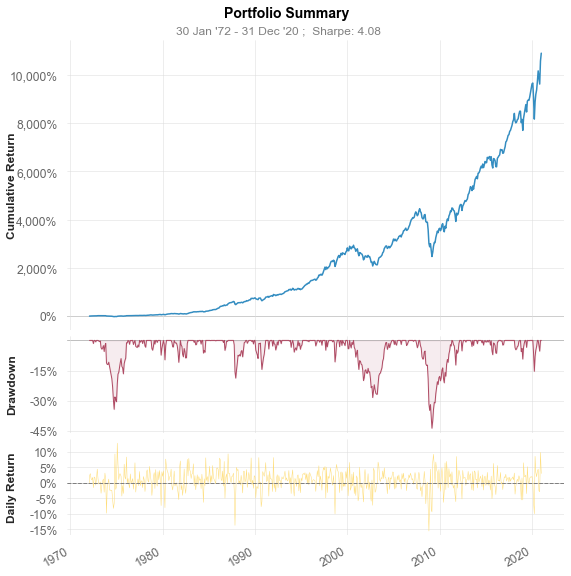

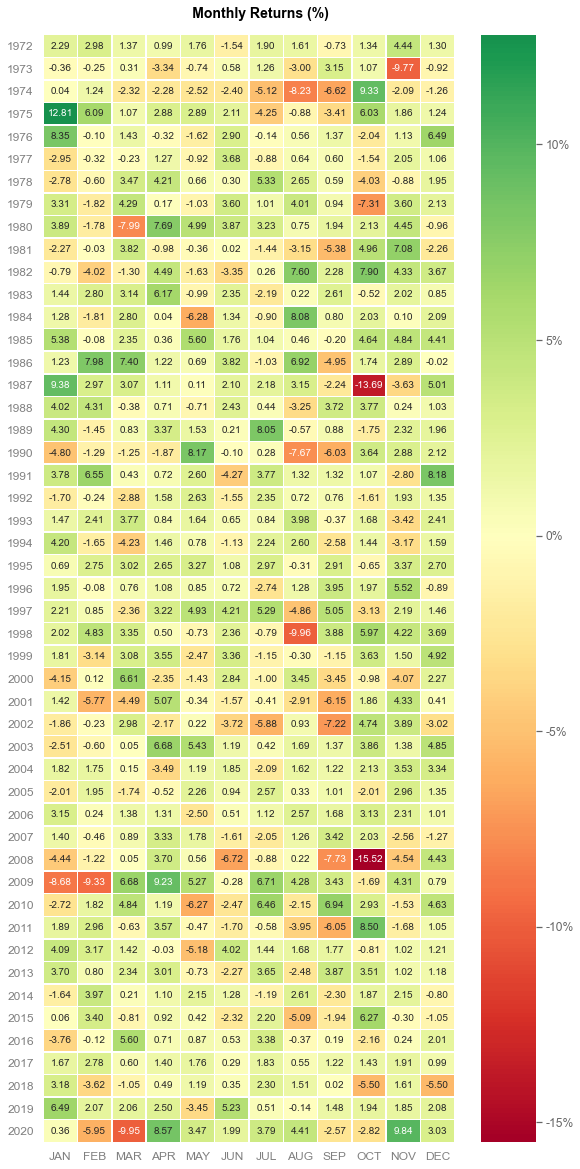

In [22]:
quantstats.reports.plots(Monthly_CoreFour['Monthly_CoreFour'], mode='basic')

연 복리 수익률 10.08%, 샤프 비율은 위에서 계산한대로 0.89, MDD는 -43%입니다. 매년 10%를 넘는 전략이지만 대공황 시기가 아닌데도 40%대 MDD는 큽니다.

In [26]:
quantstats.reports.metrics(Monthly_CoreFour['Monthly_CoreFour'], mode='full')

                           Strategy
-------------------------  ----------
Start Period               1972-01-31
End Period                 2020-12-31
Risk-Free Rate             0.0%
Time in Market             100.0%

Cumulative Return          10,906.82%
CAGR%                      10.08%
Sharpe                     4.08
Sortino                    6.48
Max Drawdown               -43.52%
Longest DD Days            1492
Volatility (ann.)          52.97%
Calmar                     0.23
Skew                       -0.53
Kurtosis                   2.11

Expected Daily %           0.8%
Expected Monthly %         0.8%
Expected Yearly %          10.07%
Kelly Criterion            32.48%
Risk of Ruin               0.0%
Daily Value-at-Risk        -4.63%
Expected Shortfall (cVaR)  -4.63%

Payoff Ratio               1.02
Profit Factor              1.97
Common Sense Ratio         2.46
CPC Index                  1.32
Tail Ratio                 1.25
Outlier Win Ratio          3.22
Outlier Loss Ratio     